# Sensory-CoKGE: Basic Workflow Demo

This notebook demonstrates how to use **Sensory-CoKGE** to convert text-based food attributes into numerical embeddings.

## What is Sensory-CoKGE?

Sensory-CoKGE helps food researchers quantify sensory descriptions by:
- Converting text descriptors ("sweet", "fruity") into numerical vectors
- Preserving hierarchical relationships using knowledge graphs
- Evaluating embedding quality against graph structure

**Paper:** Chang, Y.-T., & Chen, S.-F. (2026). Sensory-CoKGE: A contextualized knowledge graph embedding framework. *Expert Systems with Applications*, 299(C), 130191. https://doi.org/10.1016/j.eswa.2025.130191

## Step 1: Setup and Installation

Install the package and import necessary modules.

In [1]:
# Installation (uncomment if needed)
# !pip install sensory-cokge

import sensory_cokge
from sensory_cokge import (
    build_graph_from_hierarchy,
    validate_graph_structure,
    create_context_template,
    compute_embeddings,
    embeddings_to_csv,
    evaluate_embeddings,
    cosine_similarity
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

print(f"✓ Sensory-CoKGE version: {sensory_cokge.__version__}")
print(f"✓ Ready to start!")

✓ Sensory-CoKGE version: 0.1.0
✓ Ready to start!


## Step 2: Define Your Sensory Attributes

Create a hierarchical structure of chocolate taste descriptors using a simple nested dictionary.

In [2]:
# Define chocolate taste attributes as a hierarchy
chocolate_attributes = {
    'sweet': ['honey', 'caramel', 'vanilla', 'sugar'],
    'bitter': ['cocoa', 'dark', 'burnt'],
    'fruity': {
        'berry': ['raspberry', 'strawberry', 'cherry'],
        'citrus': ['orange', 'lemon']
    },
    'nutty': ['almond', 'hazelnut', 'walnut'],
    'spicy': ['cinnamon', 'chili', 'ginger']
}

print("Chocolate Sensory Hierarchy:")
print("="*60)
for category, items in chocolate_attributes.items():
    if isinstance(items, dict):
        print(f"\n{category}:")
        for subcat, subitems in items.items():
            print(f"  {subcat}: {', '.join(subitems)}")
    else:
        print(f"\n{category}: {', '.join(items)}")

Chocolate Sensory Hierarchy:

sweet: honey, caramel, vanilla, sugar

bitter: cocoa, dark, burnt

fruity:
  berry: raspberry, strawberry, cherry
  citrus: orange, lemon

nutty: almond, hazelnut, walnut

spicy: cinnamon, chili, ginger


## Step 3: Build the Description Graph

Convert your hierarchy into a knowledge graph (DAG - Directed Acyclic Graph).

In [3]:
# Build the graph from hierarchy
graph = build_graph_from_hierarchy(
    chocolate_attributes,
    graph_name='chocolate_taste_wheel'
)

print(f"✓ Graph created: {graph.graph_name}")
print(f"  Total descriptors: {len(graph.descriptions)}")
print(f"  Total connections: {len(graph.graph.es)}")
print(f"  Graph name: {graph.graph_name}")

# List some descriptors
print(f"\nSample descriptors: {graph.descriptions[:10]}")

✓ Graph created: chocolate_taste_wheel
  Total descriptors: 26
  Total connections: 25
  Graph name: chocolate_taste_wheel

Sample descriptors: ['chocolate', 'sweet', 'honey', 'caramel', 'vanilla', 'sugar', 'bitter', 'cocoa', 'dark', 'burnt']


## Step 4: Validate Your Graph

Check that the graph is properly structured (no cycles, all nodes reachable).

In [4]:
# Validate graph structure
validation = validate_graph_structure(graph)

print("Graph Validation Results:")
print("="*60)
print(f"Valid: {validation['is_valid']}")
print(f"Is DAG: {validation['is_dag']}")
print(f"Has root: {validation['has_root']}")
print(f"All reachable: {validation['all_reachable']}")

print("\nIssues/Messages:")
for issue in validation['issues']:
    print(f"  - {issue}")

print("\nStatistics:")
stats = validation['statistics']
print(f"  Descriptors: {stats['num_descriptions']}")
print(f"  Connections: {stats['num_connections']}")
print(f"  Root: {stats['root_name']}")

Graph Validation Results:
Valid: True
Is DAG: True
Has root: True
All reachable: True

Issues/Messages:
  - Graph structure is valid!

Statistics:
  Descriptors: 26
  Connections: 25
  Root: chocolate


## Step 5: Create Context Template

Define how to contextualize descriptors in sentences for the language model.

In [5]:
# Create context template for chocolate
context = create_context_template('chocolate', 'has', '{0} {1} taste')

print(f"Context template: {context}")
print("\nExamples of how descriptors will be contextualized:")
print("  'sweet' → This chocolate has a sweet taste.")
print("  'fruity' → This chocolate has a fruity taste.")
print("  'nutty' → This chocolate has a nutty taste.")

Context template: This chocolate has {0} {1} taste.

Examples of how descriptors will be contextualized:
  'sweet' → This chocolate has a sweet taste.
  'fruity' → This chocolate has a fruity taste.
  'nutty' → This chocolate has a nutty taste.


## Step 6: Compute Embeddings

Transform text descriptors into numerical vectors using a language model.

In [6]:
# Get all descriptors (excluding root)
all_attributes = [desc for desc in graph.descriptions if desc != 'chocolate']

print(f"Computing embeddings for {len(all_attributes)} descriptors...")
print(f"Using model: BERT")
print(f"Context: {context}")
print("\nThis may take a minute...\n")

# Compute embeddings
bert_embeddings = compute_embeddings(
    all_attributes,
    model_name='BERT',
    context=context,
    batch_size=4,
    device='auto'  # Automatically uses GPU if available
)

print(f"✓ Embeddings computed!")
print(f"\nEmbedding details:")
first_key = list(bert_embeddings.keys())[0]
first_emb = bert_embeddings[first_key]['encoder_embedding']
print(f"  Descriptor: '{bert_embeddings[first_key]['description']}'")
print(f"  Embedding shape: {first_emb.shape}")
print(f"  Embedding type: {type(first_emb)}")

Computing embeddings for 25 descriptors...
Using model: BERT
Context: This chocolate has {0} {1} taste.

This may take a minute...

✓ Embeddings computed!

Embedding details:
  Descriptor: 'sweet'
  Embedding shape: torch.Size([768])
  Embedding type: <class 'torch.Tensor'>


## Step 7: Export Embeddings to CSV

Save embeddings in a tabular format for further analysis.

In [7]:
# Export to CSV
output_path = 'chocolate_embeddings.csv'
embeddings_to_csv(bert_embeddings, output_path)

print(f"✓ Embeddings saved to: {output_path}")

# Load and preview the CSV
df = pd.read_csv(output_path)
print(f"\nCSV shape: {df.shape}")
print(f"Columns: description + {df.shape[1]-1} embedding dimensions")
print("\nFirst few rows:")
print(df.head())

Embeddings exported to chocolate_embeddings.csv
Shape: 25 descriptions x 768 dimensions
✓ Embeddings saved to: chocolate_embeddings.csv

CSV shape: (25, 769)
Columns: description + 768 embedding dimensions

First few rows:
  description     dim_0     dim_1     dim_2     dim_3     dim_4     dim_5  \
0       sweet -0.255289 -0.067839  0.073376  0.554441 -0.000324  0.044807   
1       honey -0.309037 -0.202304  0.093325  0.514782 -0.140701  0.171247   
2     caramel -0.301279 -0.078365  0.169681  0.495799 -0.048026 -0.035465   
3     vanilla -0.273070 -0.357523  0.133546  0.597396 -0.080840  0.051869   
4       sugar -0.413944 -0.243195  0.172657  0.526052 -0.162289  0.035189   

      dim_6     dim_7     dim_8  ...   dim_758   dim_759   dim_760   dim_761  \
0  0.185933  1.797075 -0.200101  ...  0.077681 -0.342674  0.406221  0.199300   
1  0.325780  1.792392 -0.237841  ...  0.054933 -0.467315  0.320303  0.177960   
2  0.384301  1.884403 -0.195455  ...  0.081376 -0.648139  0.302588  0.2573

## Step 8: Compute Similarity Between Descriptors

Use cosine similarity to measure how similar descriptors are in the embedding space.

In [8]:
# Extract embedding matrix
embedding_matrix = []
descriptor_names = []

for idx in sorted(bert_embeddings.keys()):
    descriptor_names.append(bert_embeddings[idx]['description'])
    emb = bert_embeddings[idx]['encoder_embedding']
    # Convert to numpy if it's a tensor
    if hasattr(emb, 'cpu'):
        emb = emb.cpu().numpy()
    embedding_matrix.append(emb)

embedding_matrix = np.vstack(embedding_matrix)

# Compute pairwise similarity
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine
similarity_matrix = sklearn_cosine(embedding_matrix)

# Create DataFrame
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=descriptor_names,
    columns=descriptor_names
)

print("Pairwise Cosine Similarity Matrix:")
print("="*60)
# Show a subset for readability
sample_descriptors = ['sweet', 'bitter', 'fruity', 'nutty', 'honey', 'cocoa']
sample_descriptors = [d for d in sample_descriptors if d in similarity_df.index]
print(similarity_df.loc[sample_descriptors, sample_descriptors].round(3))

Pairwise Cosine Similarity Matrix:
        sweet  bitter  fruity  nutty  honey  cocoa
sweet   1.000   0.928   0.946  0.939  0.967  0.875
bitter  0.928   1.000   0.980  0.974  0.961  0.938
fruity  0.946   0.980   1.000  0.985  0.979  0.954
nutty   0.939   0.974   0.985  1.000  0.976  0.951
honey   0.967   0.961   0.979  0.976  1.000  0.948
cocoa   0.875   0.938   0.954  0.951  0.948  1.000


## Step 9: Find Most Similar Descriptor Pairs

Identify which descriptors are most semantically similar.

In [9]:
# Find most similar pairs (excluding self-similarity)
similarity_pairs = []
for i in range(len(descriptor_names)):
    for j in range(i+1, len(descriptor_names)):
        similarity_pairs.append((
            descriptor_names[i],
            descriptor_names[j],
            similarity_matrix[i, j]
        ))

# Sort by similarity
similarity_pairs.sort(key=lambda x: x[2], reverse=True)

print("Top 10 Most Similar Descriptor Pairs:")
print("="*60)
for i, (desc1, desc2, sim) in enumerate(similarity_pairs[:10], 1):
    print(f"{i:2d}. {desc1:15s} ↔ {desc2:15s}  (similarity: {sim:.3f})")

print("\nTop 10 Least Similar Descriptor Pairs:")
print("="*60)
for i, (desc1, desc2, sim) in enumerate(similarity_pairs[-10:], 1):
    print(f"{i:2d}. {desc1:15s} ↔ {desc2:15s}  (similarity: {sim:.3f})")

Top 10 Most Similar Descriptor Pairs:
 1. orange          ↔ lemon            (similarity: 0.990)
 2. honey           ↔ caramel          (similarity: 0.989)
 3. honey           ↔ sugar            (similarity: 0.989)
 4. vanilla         ↔ sugar            (similarity: 0.988)
 5. caramel         ↔ sugar            (similarity: 0.986)
 6. caramel         ↔ fruity           (similarity: 0.986)
 7. sugar           ↔ ginger           (similarity: 0.986)
 8. honey           ↔ ginger           (similarity: 0.985)
 9. honey           ↔ vanilla          (similarity: 0.985)
10. fruity          ↔ nutty            (similarity: 0.985)

Top 10 Least Similar Descriptor Pairs:
 1. cherry          ↔ citrus           (similarity: 0.730)
 2. fruity          ↔ cherry           (similarity: 0.725)
 3. cherry          ↔ spicy            (similarity: 0.714)
 4. sweet           ↔ cherry           (similarity: 0.713)
 5. dark            ↔ chili            (similarity: 0.709)
 6. berry           ↔ cherry         

## Step 10: Evaluate Embeddings Against Graph Structure

Check how well the embeddings preserve the hierarchical relationships in your knowledge graph.
Compare models (BERT vs other LMs) and pick the best one for your food.

In [10]:
# Evaluate embeddings
print("Evaluating embeddings against graph structure (NoRB = Not count root-branch) ...\n")

roberta_embeddings = compute_embeddings(
    all_attributes,
    model_name='RoBERTa',
    context=context,
    batch_size=4,
    device='auto'  # Automatically uses GPU if available
)

bert_results = evaluate_embeddings(bert_embeddings, graph=graph)
roberta_results = evaluate_embeddings(roberta_embeddings, graph=graph)

print("="*60)
print("Evaluation Results (BERT):")
print("-"*60)
for metric, value in bert_results.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")

print("="*60)
print("Evaluation Results (RoBERTa):")
print("-"*60)
for metric, value in roberta_results.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")

print("="*60)

print("\nInterpretation:")
print("-" * 60)
print("Lower values = better alignment with graph structure")
print("The embeddings preserve hierarchical relationships when")
print("descriptors closer in the graph are also closer in embedding space.\n")

if bert_results['distances_matching_l2'] < roberta_results['distances_matching_l2']:
    print('In terms of distance_function = L2, BERT is a better model.')
else:
    print('In terms of distance_function = L2, RoBERTa is a better model.')
if bert_results['distances_matching_angle'] < roberta_results['distances_matching_angle']:
    print('In terms of distance_function = angle, BERT is a better model.')
else:
    print('In terms of distance_function = angle, RoBERTa is a better model.')

Evaluating embeddings against graph structure (NoRB = Not count root-branch) ...



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluation Results (BERT):
------------------------------------------------------------
adjacency_matching_l2: 0.3053
adjacency_matching_l2_NoRB: 0.3053
distances_matching_l2: 0.2439
distances_matching_l2_NoRB: 0.0903
adjacency_matching_angle: 0.3173
adjacency_matching_angle_NoRB: 0.3173
distances_matching_angle: 0.2511
distances_matching_angle_NoRB: 0.0904
Evaluation Results (RoBERTa):
------------------------------------------------------------
adjacency_matching_l2: 0.1036
adjacency_matching_l2_NoRB: 0.1036
distances_matching_l2: 0.1534
distances_matching_l2_NoRB: 0.1137
adjacency_matching_angle: 0.1052
adjacency_matching_angle_NoRB: 0.1052
distances_matching_angle: 0.1511
distances_matching_angle_NoRB: 0.1090

Interpretation:
------------------------------------------------------------
Lower values = better alignment with graph structure
The embeddings preserve hierarchical relationships when
descriptors closer in the graph are also closer in embedding space.

In terms of distance_

## Step 11: Visualize Embeddings (2D Projection)

Reduce embeddings to 2D for visualization.

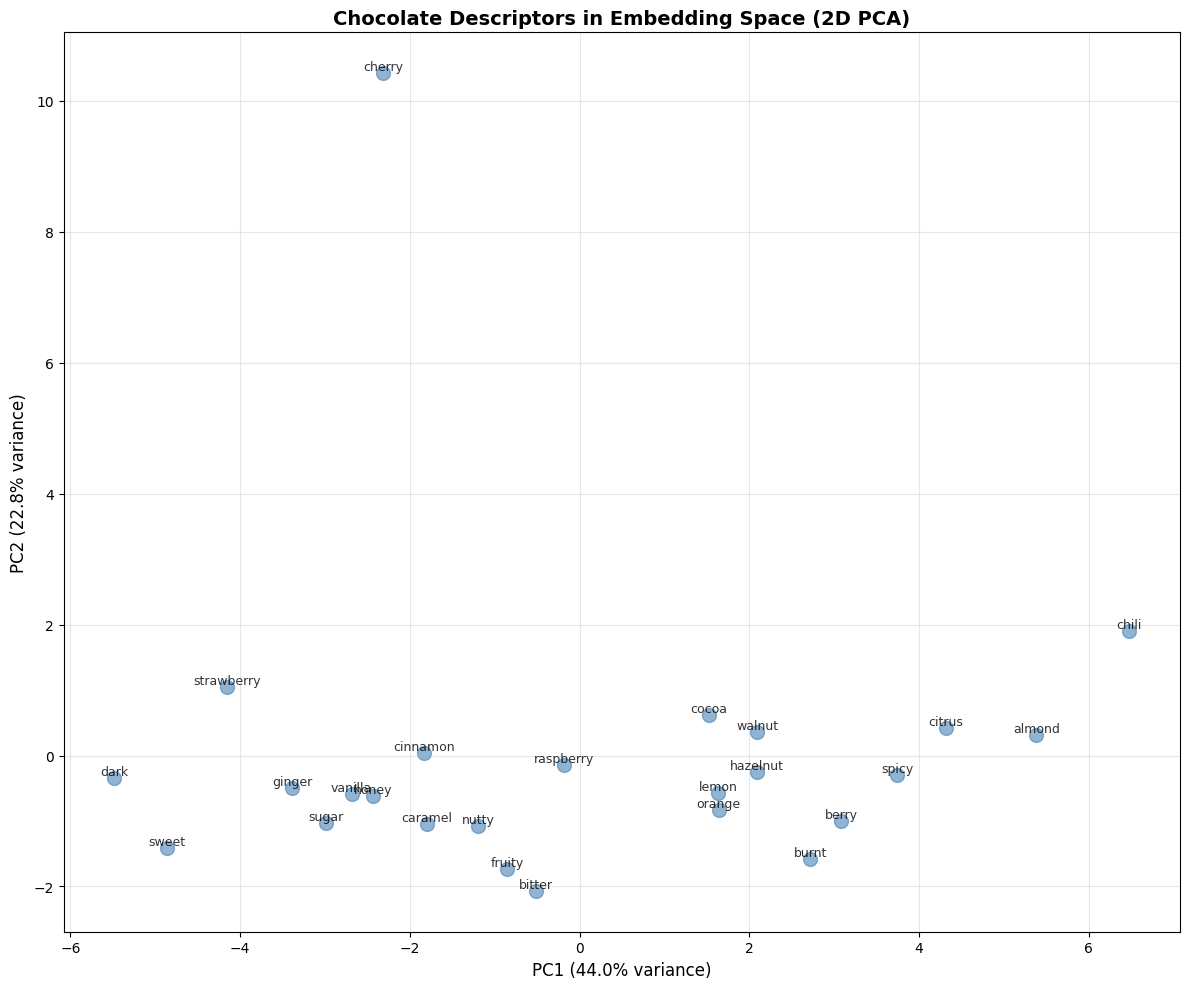

✓ Plot saved to: chocolate_embeddings_2d.png

Explained variance: 66.8%


In [11]:
from sklearn.decomposition import PCA

# Reduce to 2D
pca = PCA(n_components=2, random_state=42)
embeddings_2d = pca.fit_transform(embedding_matrix)

# Create plot
plt.figure(figsize=(12, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=100, alpha=0.6, c='steelblue')

# Annotate points
for i, descriptor in enumerate(descriptor_names):
    plt.annotate(
        descriptor,
        (embeddings_2d[i, 0], embeddings_2d[i, 1]),
        fontsize=9,
        ha='center',
        va='bottom',
        alpha=0.8
    )

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)", fontsize=12)
plt.title("Chocolate Descriptors in Embedding Space (2D PCA)", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('chocolate_embeddings_2d.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to: chocolate_embeddings_2d.png")
print(f"\nExplained variance: {pca.explained_variance_ratio_.sum():.1%}")

## Step 12: Practical Application - Find Similar Descriptors

Given a target descriptor, find the most similar ones.

In [12]:
def find_similar_descriptors(target, embeddings_dict, top_k=5):
    """
    Find descriptors most similar to the target.
    """
    # Get target embedding
    target_idx = None
    for idx, data in embeddings_dict.items():
        if data['description'] == target:
            target_idx = idx
            break
    
    if target_idx is None:
        print(f"Descriptor '{target}' not found!")
        return
    
    target_emb = embeddings_dict[target_idx]['encoder_embedding']
    if hasattr(target_emb, 'cpu'):
        target_emb = target_emb.cpu().numpy()
    target_emb = target_emb.reshape(1, -1)
    
    # Compute similarities
    similarities = []
    for idx, data in embeddings_dict.items():
        if data['description'] == target:
            continue  # Skip self
        
        emb = data['encoder_embedding']
        if hasattr(emb, 'cpu'):
            emb = emb.cpu().numpy()
        emb = emb.reshape(1, -1)
        
        sim = sklearn_cosine(target_emb, emb)[0, 0]
        similarities.append((data['description'], sim))
    
    # Sort and return top_k
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

# Test with different descriptors
test_descriptors = ['sweet', 'bitter', 'fruity']

for target in test_descriptors:
    print(f"\nMost similar to '{target}':")
    print("-" * 40)
    similar = find_similar_descriptors(target, bert_embeddings, top_k=5)
    for i, (desc, sim) in enumerate(similar, 1):
        print(f"  {i}. {desc:15s} (similarity: {sim:.3f})")


Most similar to 'sweet':
----------------------------------------
  1. sugar           (similarity: 0.973)
  2. dark            (similarity: 0.971)
  3. ginger          (similarity: 0.970)
  4. honey           (similarity: 0.967)
  5. strawberry      (similarity: 0.964)

Most similar to 'bitter':
----------------------------------------
  1. fruity          (similarity: 0.980)
  2. nutty           (similarity: 0.974)
  3. burnt           (similarity: 0.964)
  4. orange          (similarity: 0.964)
  5. caramel         (similarity: 0.964)

Most similar to 'fruity':
----------------------------------------
  1. caramel         (similarity: 0.986)
  2. nutty           (similarity: 0.985)
  3. bitter          (similarity: 0.980)
  4. honey           (similarity: 0.979)
  5. sugar           (similarity: 0.974)


## Summary and Next Steps

### What You've Learned

1. ✅ How to define sensory attributes as a hierarchy
2. ✅ How to build and validate a description graph (DAG)
3. ✅ How to create context templates for your food domain
4. ✅ How to compute embeddings from text descriptors
5. ✅ How to export embeddings to CSV for analysis
6. ✅ How to compute similarity between descriptors
7. ✅ How to evaluate embeddings against graph structure
8. ✅ How to visualize embeddings in 2D space

### Files Generated

- `chocolate_embeddings.csv` - Embeddings in tabular format
- `chocolate_embeddings_2d.png` - 2D visualization

### Next Steps

1. **Apply to Your Own Data**: Modify Step 2 with your food attributes
2. **Fine-tune Models**: Use `generate_synthetic_data()` for training data
3. **Try Different Models**: Change `model_name` in Step 6 (BERT, RoBERTa, etc.)
4. **Integrate with Your System**: Use embeddings in recommendation systems

### Resources

- **Paper**: https://doi.org/10.1016/j.eswa.2025.130191
- **GitHub**: https://github.com/b05611038/sensory-cokge
- **Issues**: https://github.com/b05611038/sensory-cokge/issues
- **Documentation**: See README.md in repository

### Citation

```bibtex
@article{chang2026sensory-cokge,
  title = {Sensory-CoKGE: A contextualized knowledge graph embedding framework using language models for converting text-based food attributes into numerical representation},
  journal = {Expert Systems with Applications},
  volume = {299},
  number = {Part C},
  year = {2026},
  doi = {10.1016/j.eswa.2025.130191},
  author = {Yu-Tang Chang and Shih-Fang Chen}
}
```